In [1]:
!pip install numpy pandas opencv-python matplotlib seaborn torch torchvision


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
# define dataset paths
dataset_path = "/home/momo/Documents/Datasets/tiny-imagenet-200"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")
test_path = os.path.join(dataset_path, "test")

# define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:

# load dataset using ImageFolder
dataset = datasets.ImageFolder(train_path, transform=transform)
train_data, val_data, test_data = random_split(dataset, [80000, 10000, 10000])

# create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# get class names
class_names = dataset.classes
num_classes = len(class_names)

# count number of images in each set
train_images_count = len(train_data)
val_images_count = len(val_data)
test_images_count = len(test_data)

# prepare summary
df_summary = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Number of Images": [train_images_count, val_images_count, test_images_count],
    "Number of Classes": [num_classes, num_classes, num_classes]
})
print(df_summary)

          Set  Number of Images  Number of Classes
0       Train             80000                200
1  Validation             10000                200
2        Test             10000                200


Sample Training Images:


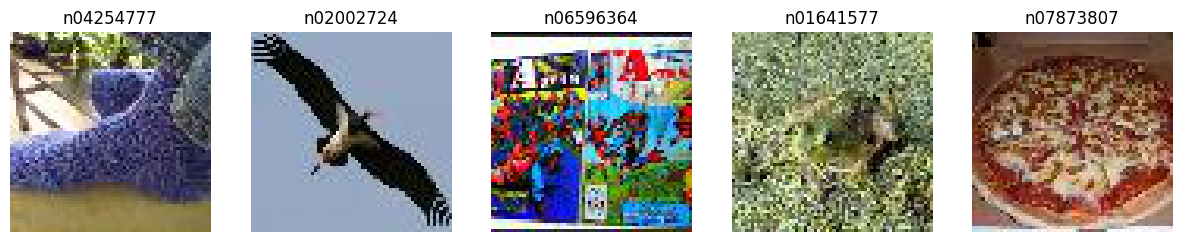

Sample Validation Images:


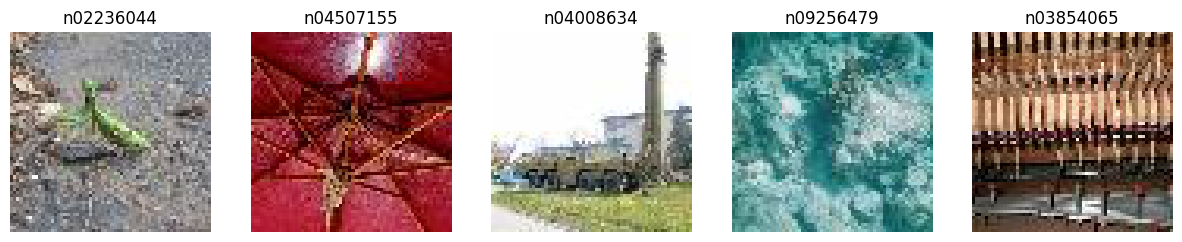

Sample Test Images:


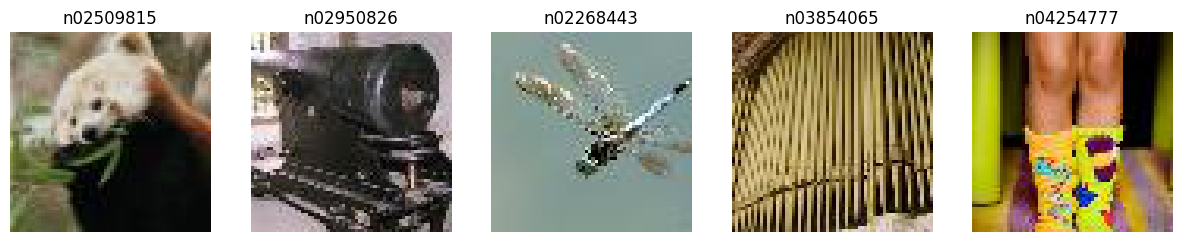

In [5]:
# visualizing some sample images
def show_sample_images(loader, num_samples=5):
    """ Display random sample images from a DataLoader """
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[labels[i]])
    plt.show()

# show some images from train, val, and test
print("Sample Training Images:")
show_sample_images(train_loader)

print("Sample Validation Images:")
show_sample_images(val_loader)

print("Sample Test Images:")
show_sample_images(test_loader)


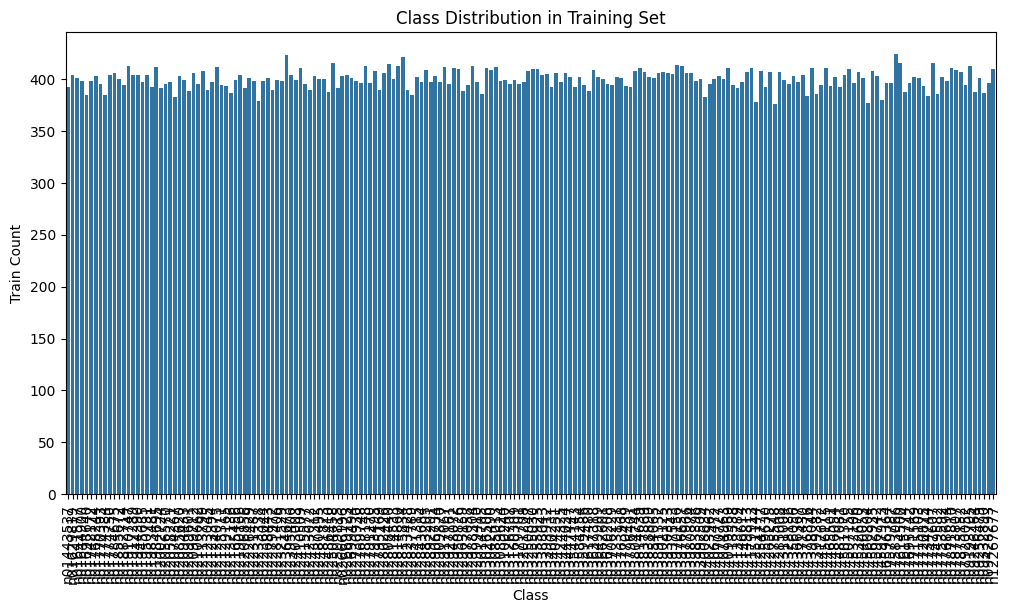

In [6]:

# count class distribution
train_class_counts = Counter([dataset.targets[i] for i in train_data.indices])
val_class_counts = Counter([dataset.targets[i] for i in val_data.indices])
test_class_counts = Counter([dataset.targets[i] for i in test_data.indices])

# convert to DataFrame
df_class_distribution = pd.DataFrame({
    "Class": class_names,
    "Train Count": [train_class_counts[i] for i in range(num_classes)],
    "Validation Count": [val_class_counts[i] for i in range(num_classes)],
    "Test Count": [test_class_counts[i] for i in range(num_classes)]
})

# plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Train Count", data=df_class_distribution)
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.show()

Augmented Sample Training Images:


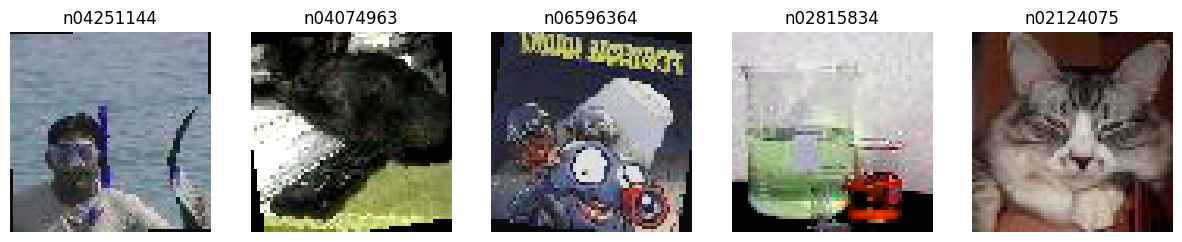

In [7]:

# data Augmentation
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_augmented = datasets.ImageFolder(train_path, transform=augmented_transform)
train_loader_augmented = DataLoader(dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=4)

# show augmented images
def show_augmented_images(loader, num_samples=5):
    """ Display random sample images with augmentations from a DataLoader """
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[labels[i]])
    plt.show()

print("Augmented Sample Training Images:")
show_augmented_images(train_loader_augmented)


In [8]:

dataset_path = "/home/momo/Documents/Datasets/tiny-imagenet-200"
train_path = dataset_path + "/train"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load dataset and ensure label consistency
dataset = datasets.ImageFolder(train_path, transform=transform)
class_to_idx = {cls: i for i, cls in enumerate(dataset.classes)}
dataset.class_to_idx = class_to_idx

# apply target transformation to ensure correct label mapping
dataset = datasets.ImageFolder(
    train_path, transform=transform,
    target_transform=lambda x: class_to_idx[dataset.classes[x]]
)

# split dataset
train_data, val_data, test_data = random_split(dataset, [80000, 10000, 10000])

# createing DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 🔹 define Correct Model Structure
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, feature_dim=512):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_features = nn.Linear(64 * 32 * 32, feature_dim)  
        self.fc_classifier = nn.Linear(feature_dim, num_classes)  

    def forward(self, x, return_features=False):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  
        features = self.fc_features(x)  
        logits = self.fc_classifier(features)  

        if return_features:
            return features  
        return logits  

# 🔹 ensure EPASS Uses a Classifier for Training
class Projector(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Projector, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.mlp(x)

class EPASS(nn.Module):
    def __init__(self, base_model, num_projectors=3, feature_dim=512, output_dim=128, num_classes=200):
        super(EPASS, self).__init__()
        self.base_model = base_model
        self.projectors = nn.ModuleList([Projector(feature_dim, output_dim) for _ in range(num_projectors)])
        self.classifier = nn.Linear(output_dim, num_classes)  

    def forward(self, x):
        features = self.base_model(x, return_features=True)  
        ensemble_embeddings = torch.stack([proj(features) for proj in self.projectors], dim=0).mean(dim=0)
        logits = self.classifier(ensemble_embeddings)  

        return logits  

class JointMatch(nn.Module):
    def __init__(self, base_model, num_classes):
        super(JointMatch, self).__init__()
        self.model1 = base_model
        self.model2 = base_model
        self.num_classes = num_classes
        self.thresholds = torch.ones(num_classes) * 0.95  # adaptive thresholds

    def update_thresholds(self, pseudo_labels):
        class_counts = torch.bincount(pseudo_labels, minlength=self.num_classes)
        class_probs = class_counts.float() / class_counts.sum()
        self.thresholds = 0.95 * (1 - class_probs) + 0.05

    def forward(self, x):
        outputs1 = self.model1(x)
        outputs2 = self.model2(x)

        # cross-labeling logic
        pseudo_labels1 = torch.argmax(outputs1, dim=1)
        pseudo_labels2 = torch.argmax(outputs2, dim=1)

        self.update_thresholds(pseudo_labels1)

        # confidence-based filtering
        high_confidence_mask1 = torch.max(outputs1, dim=1).values > self.thresholds[pseudo_labels1]
        high_confidence_mask2 = torch.max(outputs2, dim=1).values > self.thresholds[pseudo_labels2]

        # ensure that at least one set of outputs is always returned
        if high_confidence_mask2.sum() > 0:
            return outputs1
        elif high_confidence_mask1.sum() > 0:
            return outputs2
        else:
            return outputs1  # default return (prevents tuple return)

def train_model(model, train_loader, val_loader, epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)  # now always returns a tensor

            # ensure correct shape before applying loss
            assert isinstance(outputs, torch.Tensor), "Model output must be a tensor!"
            assert outputs.shape[1] == 200, f"Expected output shape [batch_size, 200], got {outputs.shape}"
            assert labels.max().item() < 200, f"Invalid Label Found: {labels.max().item()}"

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

# instantiate Models
base_model = SimpleCNN(num_classes=200)
epass_model = EPASS(base_model)
jointmatch_model = JointMatch(base_model, num_classes=200)

# train Models with Corrected Dataset
train_model(epass_model, train_loader, val_loader, epochs=3)
train_model(jointmatch_model, train_loader, val_loader, epochs=3)

# improved Model Evaluation
def compare_results(model1, model2, data_loader):
    model1.eval()
    model2.eval()
    correct1, correct2, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            outputs1 = model1(images)
            outputs2 = model2(images)

            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)

            correct1 += (predicted1 == labels).sum().item()
            correct2 += (predicted2 == labels).sum().item()
            total += labels.size(0)

    acc1 = 100 * correct1 / total
    acc2 = 100 * correct2 / total
    print(f"✅ EPASS Accuracy: {acc1:.2f}%, ✅ JointMatch Accuracy: {acc2:.2f}%")

compare_results(epass_model, jointmatch_model, val_loader)


Epoch 1, Training Loss: 4.5654
Epoch 2, Training Loss: 3.9004
Epoch 3, Training Loss: 3.4694
Epoch 1, Training Loss: 3.6924
Epoch 2, Training Loss: 2.1351
Epoch 3, Training Loss: 0.9554
✅ EPASS Accuracy: 2.94%, ✅ JointMatch Accuracy: 9.64%
